# LLM-text Detectio Contribution 1: Fail Case Analysis

**Task Definition**: Predicting whether a piece of text is generated by a Large Language Model (LLM) or not. This task takes free text as input and outputs a binary result, where 0 represents that the piece of text was not generated by an LLM, and 1 indicates that the piece of text was generated by an LLM.

**Proposed System**: We hypothesized that an LLM such as GPT-4 has certain preconceptions and a writing style similar to that of a human writer. Inspired by previous works on author attribution, we can calculate a GPT representation vector that results from averaging the sentence embeddings of GPT-generated sentences. At testing time, we can calculate the cosine similarity between the GPT representation and the sentence embedding of the testing sentence to determine whether it was generated by a human or an LLM.

1.   obtain *k* diverse samples of texts generated by LLM
2.   transform each piece of text to a sentence embedding using your chosen model
3.   average the sentence embedding to get GPT representation
4.   compute cosine similarity between GPT representation with the sentence embedding of testing text
5.   decide a threshold as a decision boundary for classifciation

**Data Sources**: We will explore three domian/scope of data sets to test when will the proposed system work and when will it fail.

**Data Domain 1**: Discover the use case when GPT text in train set has the same prompts as the GPT text in the test set. For example, when a teacher assigns an essay to students and the instructions are known to both the teacher and the students. The proposed system can ask an LLM to generate a few essays using the prompt and average each essay's sentence embeddings to obtain a GPT representation, which can later be compared to the sentence embeddings of the student's essay.
  - In this use case, we used human written data from [Human Text Data](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview) (Note: this link only provides human-generated texts for [two distinct prompts](https://drive.google.com/file/d/13i2EIEMI5Zv5MHtA2xvVdpSmMxI10vD0/view?usp=drive_link). LLM texts were generated by the team using openai API) and GPT4 generated data on the same two prompts: [LLM Text Data](https://huggingface.co/datasets/jjz5463/llm-detection-generation-1.0)

**Data Domain 2**: When GPT text in the train set does not use the same prompts as the GPT text in the test set. For example, when encountering an article online or on social media, we may want to determine whether it was generated by an LLM, even though we do not have the prompt. In this case, we propose generating a GPT dataset that covers various topics. Then, by averaging the sentence embeddings, we obtain a GPT representation. Subsequently, we compute the cosine similarity with the testing sentence for which we do not have a prompt.
  - In this use case, we identified two separate data sources to ensure there is no overlap between the prompts. One data source consists of text extracted from the FeedBack Prize 3 competition [data source 1 human text](https://www.kaggle.com/datasets/alejopaullier/daigt-external-dataset). The second data source is from ivypanda.com [datasource 2 human text](https://huggingface.co/datasets/ChristophSchuhmann/essays-with-instructions)
  - For both data sources, they provide instructions for the human text, the team used these as prompts to generate the llm texts [data source 1 llm text](https://huggingface.co/datasets/jjz5463/llm-detection-generation-contribution2-train) and [data source 2 llm text](https://huggingface.co/datasets/jjz5463/llm-detection-generation-contribution2-test)
  - The team used data source 1 as the training data for baseline model and data source 1 llm text as data to generate GPT reprsentation. Then, team evalute performance on the data source 2.

**Data Domain 3**: Extend from Data Domain 2 that GPT-text in train and test not only do not share the same prompts, test data also went through prompt engineering (attributed prompt) to twist the style of generated sentences, which make the domain shift between train and test even larger.
  - human data: same as the data domain 2
  - GPT-data train: same as the data domain 2 (data source 1 llm text)
  - GPT-data test: https://huggingface.co/datasets/jjz5463/llm-detection-generation-failcase-test

**Baseline**: Roberta w/o finetuning & Roberta w/ finetunning

**Contribution 1**: Failure case analysis
**Contribution 2**: Model extension to fix fail case

**Scope**: (1) The team is using GPT-4 for the LLM due to the availability of its API. (2) Moreover, the team assumes that fancier prompt engineering methods, such as attributed prompts and few-shot learning, which may completely remove GPT's own style, are not used here.

# Dependencies

In [ ]:
%%capture
!pip install -U gdown
!pip install torch
!pip install accelerate -U
!pip install transformers[torch]
!pip install datasets
!pip install sentence_transformers

In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, RobertaModel
import torch
from torch.nn.functional import normalize, cosine_similarity
from torch.utils.data import DataLoader, Dataset

# Usecase 1

Discover the use case when we know what the prompts are. For example, when a teacher assigns an essay to students and the instructions are known to both the teacher and the students.

*The proposed system*:

1.   use instruction as prompts to generate *k* LLM essays
2.   generate sentence embedding for each essay
3.   average each essay's sentence embeddings to obtain a GPT representation
4.   in testing time, compare to the sentence embeddings of the student's essay

*Data source*:

- [Human Text Data](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview)

- [LLM Text Data](https://huggingface.co/datasets/jjz5463/llm-detection-generation-1.0)

## Data Loading

In [ ]:
# Data Download
%%capture
!gdown 130Visooi9SxFePbEqD4fkuUogRg_ZI8V

In [ ]:
# Load Data
%%capture
human_text = pd.read_csv('human_written.csv')[['prompt_id', 'text']]
llm_text = pd.DataFrame(load_dataset('jjz5463/llm-detection-generation-1.0', split='train'))

In [ ]:
# format the llm_text to match human_text
substring_to_match = 'Write a letter to your state senator in which you argue in favor of keeping the Electoral College'
llm_text['prompts'] = llm_text['prompts'].str.contains(substring_to_match, case=False).astype(int)
llm_text.rename(columns={'prompts': 'prompt_id', 'generations by the LLM.': 'text'}, inplace=True)

## EDA

In [ ]:
# take a look at human texts
pd.concat([human_text[human_text['prompt_id'] == 0].head(1), human_text[human_text['prompt_id'] == 1].head(1)])

,prompt_id,text
0,0,Cars. Cars have been around since they became ...
5,1,The electrol college system is an unfair syste...


In [ ]:
# take a look at llm essays
pd.concat([llm_text[llm_text['prompt_id']==0].head(1),llm_text[llm_text['prompt_id']==1].head(1)])

,prompt_id,text
0,0,In an era where environmental conservation is ...
1000,1,"The Electoral College, a process embedded in o..."


In [ ]:
# Explore the distribution of prompt_id in human_text
human_text_distribution = human_text['prompt_id'].value_counts()
# Explore the distribution of prompt_id in llm_text
llm_text_distribution = llm_text['prompt_id'].value_counts()
human_text_distribution, llm_text_distribution

(prompt_id
 0    707
 1    668
 Name: count, dtype: int64,
 prompt_id
 0    1000
 1    1000
 Name: count, dtype: int64)

In [ ]:
# make sure llm_text has the same number as human_text
llm_text_0_sampled = llm_text[llm_text['prompt_id'] == 0].sample(n=human_text_distribution[0])
llm_text_1_sampled = llm_text[llm_text['prompt_id'] == 1].sample(n=human_text_distribution[1])
llm_text = pd.concat([llm_text_0_sampled, llm_text_1_sampled])

# recheck distribution of prompt_id
human_text_distribution = human_text['prompt_id'].value_counts()
llm_text_distribution = llm_text['prompt_id'].value_counts()
human_text_distribution, llm_text_distribution

(prompt_id
 0    707
 1    668
 Name: count, dtype: int64,
 prompt_id
 0    707
 1    668
 Name: count, dtype: int64)

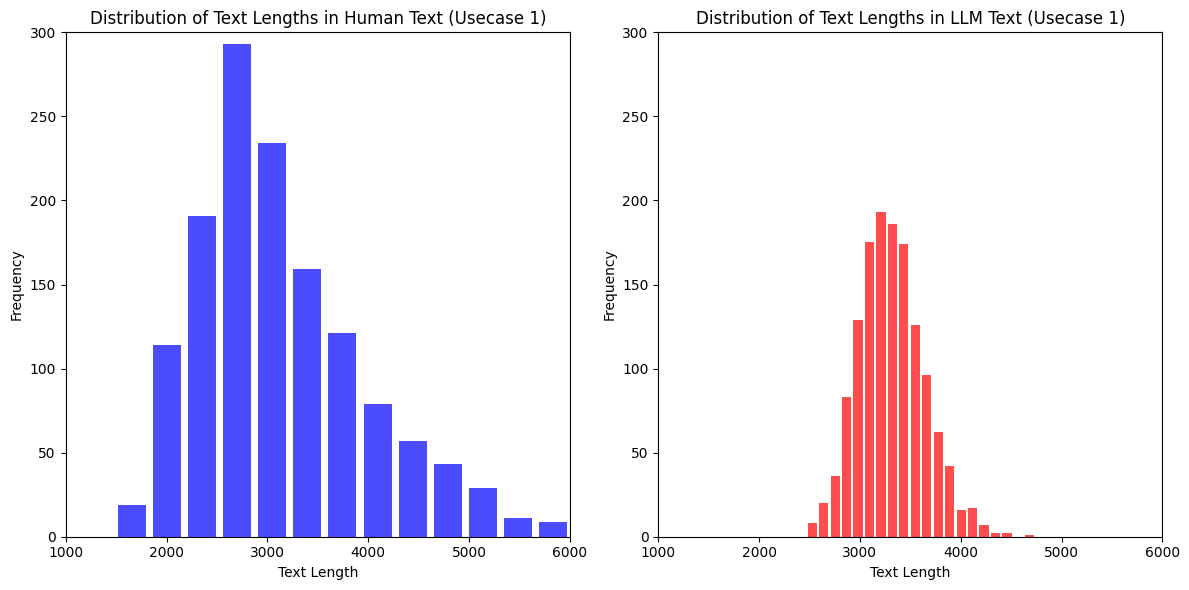

In [ ]:
# Calculate text length
human_text_length = human_text['text'].apply(len)
llm_text_length = llm_text['text'].apply(len)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(human_text_length, bins=20, alpha=0.7, label='Human Text', color='blue', rwidth=0.8)
plt.title('Distribution of Text Lengths in Human Text (Usecase 1)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.ylim(0,300)
plt.xlim(1000, 6000)

plt.subplot(1, 2, 2)
plt.hist(llm_text_length, bins=20, alpha=0.7, color='red', label='LLM Text', rwidth=0.8)
plt.title('Distribution of Text Lengths in LLM Text (Usecase 1)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.ylim(0,300)
plt.xlim(1000, 6000)

plt.tight_layout()
plt.show()

## Baseline: Roberta No Finetuning

Standard Roberta binary classification

![Alt text](https://media.geeksforgeeks.org/wp-content/uploads/20230802120409/Single-Sentence-Classification-Task.png)


In [ ]:
# Combine datasets with labels
human_text['label'] = 0
llm_text['label'] = 1
data = pd.concat([human_text, llm_text])

# Splitting the data
train_data, test_data = train_test_split(data, test_size=0.7, stratify=data['label'], random_state=42)
dev_data, test_data = train_test_split(test_data, test_size=0.9, stratify=test_data['label'], random_state=42)

In [ ]:
print(f"number of human text in train: {sum(train_data['label']==0)}")
print(f"number of gpt text in train: {sum(train_data['label']==1)}")

number of human text in train: 412
number of gpt text in train: 413


In [ ]:
print(f"number of human text in dev: {sum(dev_data['label']==0)}")
print(f"number of gpt text in dev: {sum(dev_data['label']==1)}")

number of human text in dev: 96
number of gpt text in dev: 96


In [ ]:
print(f"number of human text in test: {sum(test_data['label']==0)}")
print(f"number of gpt text in test: {sum(test_data['label']==1)}")

number of human text in test: 867
number of gpt text in test: 866


In [ ]:
# Preparing the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
baseline_u1_nf = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

for param in baseline_u1_nf.roberta.parameters():
    param.requires_grad = False

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(list(examples['text']), padding="max_length", truncation=True)

train_encodings = tokenize_function(train_data)
test_encodings = tokenize_function(test_data)

# Convert to torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_data['label'].tolist())
test_dataset = Dataset(test_encodings, test_data['label'].tolist())

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Initialize the trainer
trainer1 = Trainer(
    model=baseline_u1_nf,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer1.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=312, training_loss=0.6718412546011118, metrics={'train_runtime': 80.107, 'train_samples_per_second': 30.896, 'train_steps_per_second': 3.895, 'total_flos': 651199862016000.0, 'train_loss': 0.6718412546011118, 'epoch': 3.0})

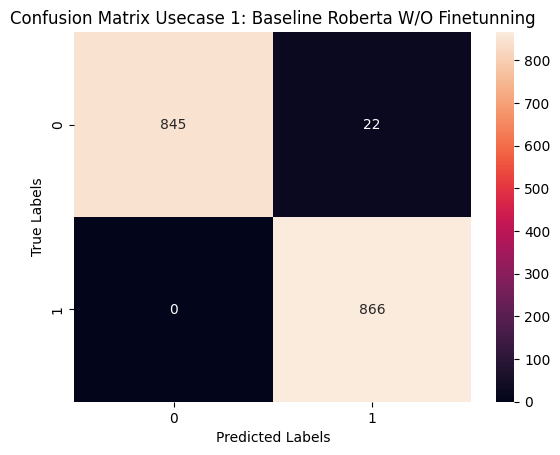

Accuracy: 0.9873052510098096
Precision: 0.9752252252252253
Recall: 1.0
F1 Score: 0.9874572405929305


In [ ]:
# Evaluation
predictions = trainer1.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Calculate metrics
accuracy = accuracy_score(test_data['label'], preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_data['label'], preds, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(test_data['label'], preds)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix Usecase 1: Baseline Roberta W/O Finetunning')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

## Baseline: Roberta W/ Finetunning

In [ ]:
# Preparing the tokenizer and model
baseline_u1_wf = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Initialize the trainer
trainer2 = Trainer(
    model=baseline_u1_wf,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer2.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=312, training_loss=0.1711248740171775, metrics={'train_runtime': 266.0767, 'train_samples_per_second': 9.302, 'train_steps_per_second': 1.173, 'total_flos': 651199862016000.0, 'train_loss': 0.1711248740171775, 'epoch': 3.0})

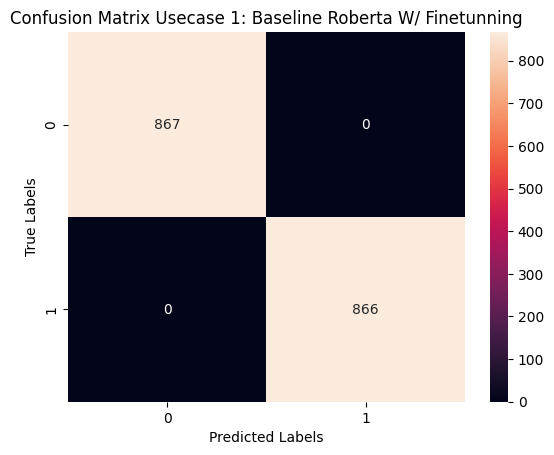

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [ ]:
# Evaluation
predictions = trainer2.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Calculate metrics
accuracy = accuracy_score(test_data['label'], preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_data['label'], preds, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(test_data['label'], preds)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix Usecase 1: Baseline Roberta W/ Finetunning')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

## Proposed System

Compute a GPT representation -> then compute cosine similarity with every test sentence

*GPT representation process*:
  1. decide a model use to generate sentence embedding. In this case, it is roberta + mean pooling. We extract the last hidden layer of roberta which contain an embedding for every token in the sentence, then we perform mean pooling over token embedding to get sentence embedding
  2. normalize each sentence embedding
  3. then we average sentence embedding to get GPT representation

<figure>
<center>
<img src='https://drive.google.com/uc?id=1dptlTebQSWAZepjJOfhh_vN7foShMkmp' width="500" height="680"/>
<figcaption>Proposed System</figcaption></center>
</figure>

### train: gpt representation

In [ ]:
#@title archive train code

# # Load RoBERTa tokenizer and model
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base')

# # Example sentence
# encoded_input = tokenizer(gpt_sentences, return_tensors='pt', padding=True, truncation=True)

# # Get model output (without pooling)
# with torch.no_grad():
#     model_output = model(**encoded_input)
#     embeddings = model_output.last_hidden_state

# # Perform mean pooling
# input_mask_expanded = encoded_input['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
# sum_embeddings = torch.sum(embeddings * input_mask_expanded, 1)
# sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
# mean_pooled = sum_embeddings / sum_mask

# # Normalize each mean-pooled embedding
# normalized_embeddings1 = normalize(mean_pooled, p=2, dim=1)

In [ ]:
from sentence_transformers import SentenceTransformer

# we are using the genreated sentence in the train to produce GPT represetnation
gpt_sentences_u1 = list(train_data[train_data['label']==1]['text'])

base_roberta = SentenceTransformer('roberta-base')
usecase1_train_embeddings = base_roberta.encode(gpt_sentences_u1)
print("Use case 1 train embeddings shape:", usecase1_train_embeddings.shape)  # Shape after normalization

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Use case 1 train embeddings shape: (413, 768)


In [ ]:
# Compute the overall GPT representation by averaging normalized embeddings
gpt_representation1 = usecase1_train_embeddings.mean(axis=0)

### dev: pick a threshold

In [ ]:
#@title archive dev code

# # dev embeddings
# class TestDataset(Dataset):
#     def __init__(self, texts):
#         self.texts = texts

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         return self.texts[idx]

# batch_size = 800

# dev_sentences = list(dev_data['text'])
# dev_dataset = TestDataset(dev_sentences)
# dev_loader = DataLoader(dev_dataset,
#                          batch_size=batch_size, shuffle=False)

# dev_normalized_embeddings1 = []

# for batch in dev_loader:
#     dev_encoded = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)

#     # Compute embeddings
#     with torch.no_grad():
#         dev_output = model(**dev_encoded)
#         embeddings = dev_output.last_hidden_state

#     # Mean pooling and normalization
#     dev_input_mask_expanded = dev_encoded['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
#     dev_sum_embeddings = torch.sum(embeddings * dev_input_mask_expanded, 1)
#     dev_sum_mask = torch.clamp(dev_input_mask_expanded.sum(1), min=1e-9)
#     dev_mean_pooled = dev_sum_embeddings / dev_sum_mask
#     normalized_embeddings = normalize(dev_mean_pooled, p=2, dim=1)

#     # Append the results
#     dev_normalized_embeddings1.append(normalized_embeddings)

# # Concatenate all batch results
# dev_normalized_embeddings1 = torch.cat(dev_normalized_embeddings1, dim=0)

# print("dev embeddings shape:", dev_normalized_embeddings1.shape)

In [ ]:
dev_sentences_u1 = list(dev_data['text'])
usecase1_dev_embeddings = base_roberta.encode(dev_sentences_u1)
print("Use case 1 dev embeddings shape:", usecase1_dev_embeddings.shape)  # Shape after normalization

Use case 1 dev embeddings shape: (192, 768)


In [ ]:
type(usecase1_dev_embeddings)

numpy.ndarray

In [ ]:
# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_dev1 = cosine_similarity(torch.from_numpy(gpt_representation1), torch.from_numpy(usecase1_dev_embeddings))

# Flatten cosine similarities to a list for easier processing
cosine_similarities_dev1 = cosine_similarities_dev1.flatten().numpy()

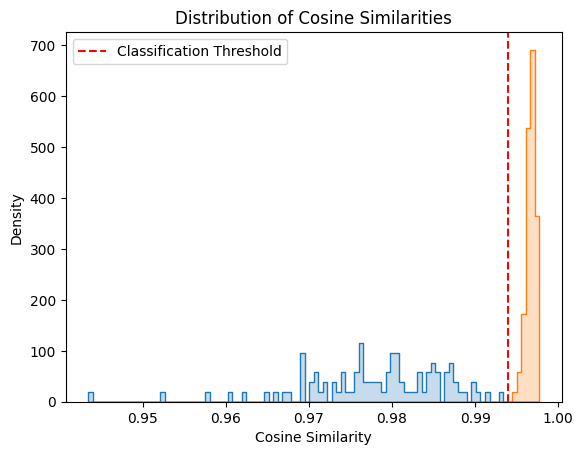

In [ ]:
threshold1 = 0.994

sns.histplot(x=cosine_similarities_dev1, hue=dev_data['label'], element='step', stat='density', common_norm=False, bins=100)
plt.axvline(x=threshold1, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

### test

In [ ]:
#@title archive test code

# # test
# test_sentences = list(test_data['text'])
# test_dataset = TestDataset(test_sentences)
# test_loader = DataLoader(test_dataset,
#                          batch_size=batch_size, shuffle=False)

# test_normalized_embeddings = []

# for batch in test_loader:
#     test_encoded = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)

#     # Compute embeddings
#     with torch.no_grad():
#         test_output = model(**test_encoded)
#         embeddings = test_output.last_hidden_state

#     # Mean pooling and normalization
#     test_input_mask_expanded = test_encoded['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
#     test_sum_embeddings = torch.sum(embeddings * test_input_mask_expanded, 1)
#     test_sum_mask = torch.clamp(test_input_mask_expanded.sum(1), min=1e-9)
#     test_mean_pooled = test_sum_embeddings / test_sum_mask
#     normalized_embeddings = normalize(test_mean_pooled, p=2, dim=1)

#     # Append the results
#     test_normalized_embeddings.append(normalized_embeddings)

# # Concatenate all batch results
# test_normalized_embeddings = torch.cat(test_normalized_embeddings, dim=0)

# print("Test embeddings shape:", test_normalized_embeddings.shape)

In [ ]:
test_sentences_u1 = test_sentences = list(test_data['text'])
usecase1_test_embeddings = base_roberta.encode(test_sentences_u1)
print("Use case 1 test embeddings shape:", usecase1_test_embeddings.shape)  # Shape after normalization

Use case 1 test embeddings shape: (1733, 768)


In [ ]:
# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_test1 = cosine_similarity(torch.from_numpy(gpt_representation1), torch.from_numpy(usecase1_test_embeddings))

# Flatten cosine similarities to a list for easier processing
cosine_similarities_test1 = cosine_similarities_test1.flatten().numpy()

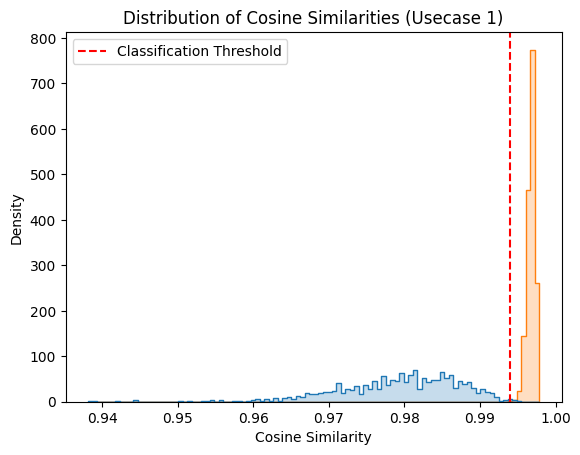

In [ ]:
sns.histplot(x=cosine_similarities_test1, hue=test_data['label'], element='step', stat='density', common_norm=False, bins=100)
plt.axvline(x=threshold1, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities (Usecase 1)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

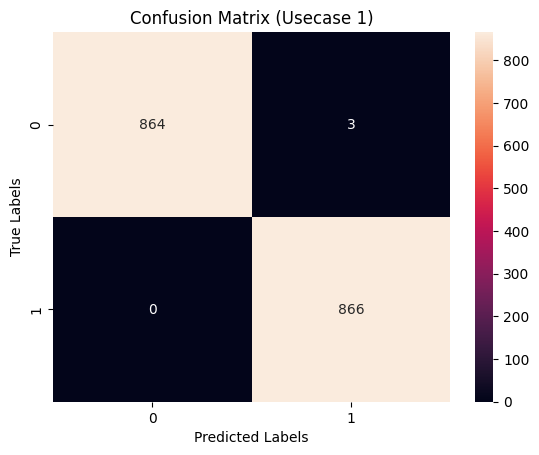

Accuracy: 0.9982688978649741
Precision: 0.996547756041427
Recall: 1.0
F1 Score: 0.998270893371758


In [ ]:
predicted_labels = (cosine_similarities_test1 > threshold1).astype(int)

# Calculate metrics
accuracy = accuracy_score(test_data['label'], predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_data['label'], predicted_labels, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(test_data['label'], predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Usecase 1)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Usecase 2

In use case 2, we will apply the baseline and proposed system to a differnet domain and use case where we do not know the prompts ahead. Therefore, the training data and testing data are generated by differnet prompts. Human written dataset are found online, all LLM dataset are generated by the team.

To ensure the team did not accidently include same prompt in both training and testing, we find two separate source online as human data:

* Training data
  - [data source 1 human text](https://www.kaggle.com/datasets/alejopaullier/daigt-external-dataset) the team only use the text column, which is student written (human) and the team use the provided instruction to generate correspond GPT4 text using API. [data source 1 llm text](https://huggingface.co/datasets/jjz5463/llm-detection-generation-contribution2-train)
  - By training data, the team use it to train the baseline model. The proposed system has no training phase and only use the llm text part of data source 1

* Dev & Testing data
  - [datasource 2 human text](https://huggingface.co/datasets/ChristophSchuhmann/essays-with-instructions) the team only use essays here as the human text, then team use instruction to generate correspond GPT4 text using API [data source 2 llm text](https://huggingface.co/datasets/jjz5463/llm-detection-generation-contribution2-test)


## data loading

In [ ]:
# download data
!gdown 1AHlj3HRqv4DStCkVOk6OALp8JpRO_CZW

Downloading...
From: https://drive.google.com/uc?id=1AHlj3HRqv4DStCkVOk6OALp8JpRO_CZW
To: /content/contribution2_train_human_text.csv
100% 6.41M/6.41M [00:00<00:00, 34.5MB/s]


In [ ]:
# loading data source 1
data_source_1_human = pd.read_csv('domain2_train_human_text.csv')[['text']]
data_source_1_human['label'] = 0
data_source_1_human.shape

(2421, 2)

In [ ]:
%%capture
data_source_1_llm = pd.DataFrame(
    load_dataset('jjz5463/llm-detection-generation-contribution2-train',
                 split='train')
    )[['generations by the LLM.']]
data_source_1_llm.rename(columns={'generations by the LLM.': 'text'}, inplace=True)
data_source_1_llm['label'] = 1

In [ ]:
data_source_1_llm.shape

(2421, 2)

In [ ]:
%%capture
# loading data source 2
data_source_2_human = pd.DataFrame(
    load_dataset('ChristophSchuhmann/essays-with-instructions',
                 split='train')
    )[['essays']]
data_source_2_human.rename(columns={'essays': 'text'}, inplace=True)
data_source_2_human['label'] = 0

In [ ]:
data_source_2_human.shape

(2064, 2)

In [ ]:
data_source_2_llm = pd.DataFrame(
    load_dataset('jjz5463/llm-detection-generation-contribution2-test',
                 split='train')
    )[['generations by the LLM.']]
data_source_2_llm.rename(columns={'generations by the LLM.': 'text'}, inplace=True)
data_source_2_llm['label'] = 1
data_source_2_llm.shape

Generating train split:   0%|          | 0/2064 [00:00<?, ? examples/s]

(2064, 2)

In [ ]:
# training data
ctr2_train_data = pd.concat([data_source_1_human, data_source_1_llm])
ctr2_train_data.shape

(4842, 2)

In [ ]:
ctr2_train_data[ctr2_train_data['label']==1].shape

(2421, 2)

In [ ]:
ctr2_train_data[ctr2_train_data['label']==0].shape

(2421, 2)

In [ ]:
# testing data
ctr2_test_data = pd.concat([data_source_2_human, data_source_2_llm])

# dev data
ctr2_dev_data, ctr2_test_data = train_test_split(ctr2_test_data, test_size=0.9, stratify=ctr2_test_data['label'], random_state=42)
ctr2_test_data.shape

(3716, 2)

In [ ]:
ctr2_dev_data.shape

(412, 2)

In [ ]:
ctr2_dev_data[ctr2_dev_data['label']==1].shape

(206, 2)

In [ ]:
ctr2_dev_data[ctr2_dev_data['label']==0].shape

(206, 2)

In [ ]:
ctr2_test_data[ctr2_test_data['label']==1].shape

(1858, 2)

In [ ]:
ctr2_test_data[ctr2_test_data['label']==0].shape

(1858, 2)

## EDA

In [ ]:
topics_source1 = pd.read_csv('contribution2_train_human_text.csv')['instructions']
print(f'number of distinct instructions in the source 1 (train): {len(set(topics_source1))}')

number of distinct instructions in the source 1 (train): 2420


In [ ]:
topics_source2 = pd.DataFrame(
    load_dataset('ChristophSchuhmann/essays-with-instructions',
                 split='train')
    )['instructions']
print(f'number of distinct instructions in the source 2 (test): {len(set(topics_source2))}')

number of distinct instructions in the source 2 (test): 2064


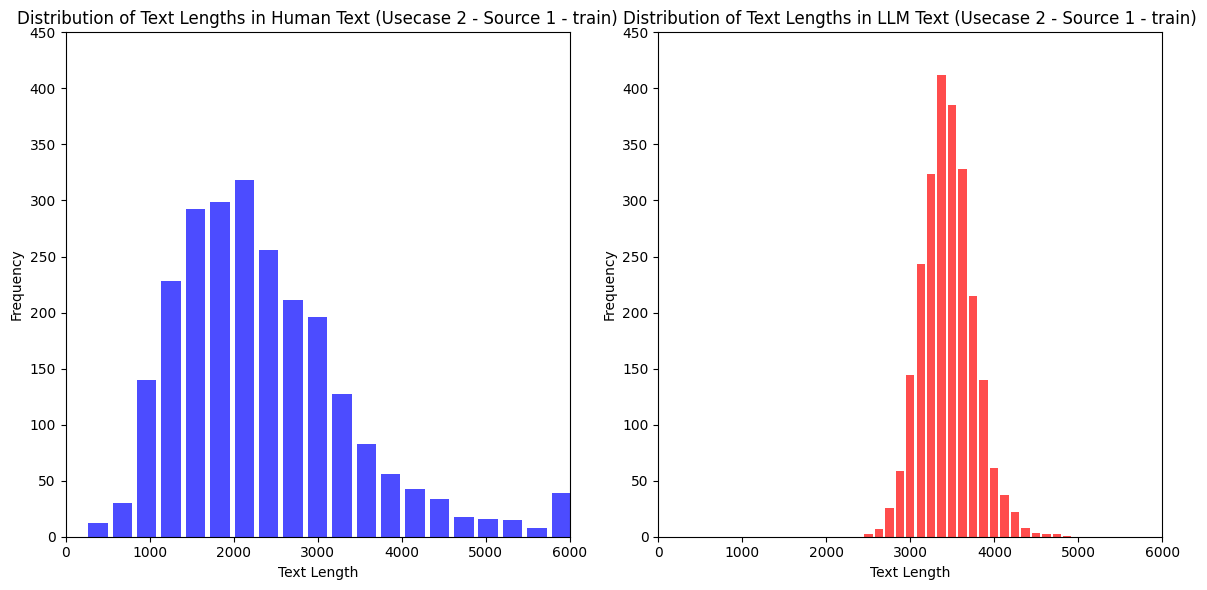

In [ ]:
# Calculate text length in data source 1
human_text_length = data_source_1_human['text'].apply(len)
llm_text_length = data_source_1_llm['text'].apply(len)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(human_text_length, bins=20, alpha=0.7, label='Human Text', color='blue', rwidth=0.8)
plt.title('Distribution of Text Lengths in Human Text (Usecase 2 - Source 1 - train)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.ylim(0, 450)
plt.xlim(0, 6000)

plt.subplot(1, 2, 2)
plt.hist(llm_text_length, bins=20, alpha=0.7, color='red', label='LLM Text', rwidth=0.8)
plt.title('Distribution of Text Lengths in LLM Text (Usecase 2 - Source 1 - train)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.ylim(0, 450)
plt.xlim(0, 6000)

plt.tight_layout()
plt.show()

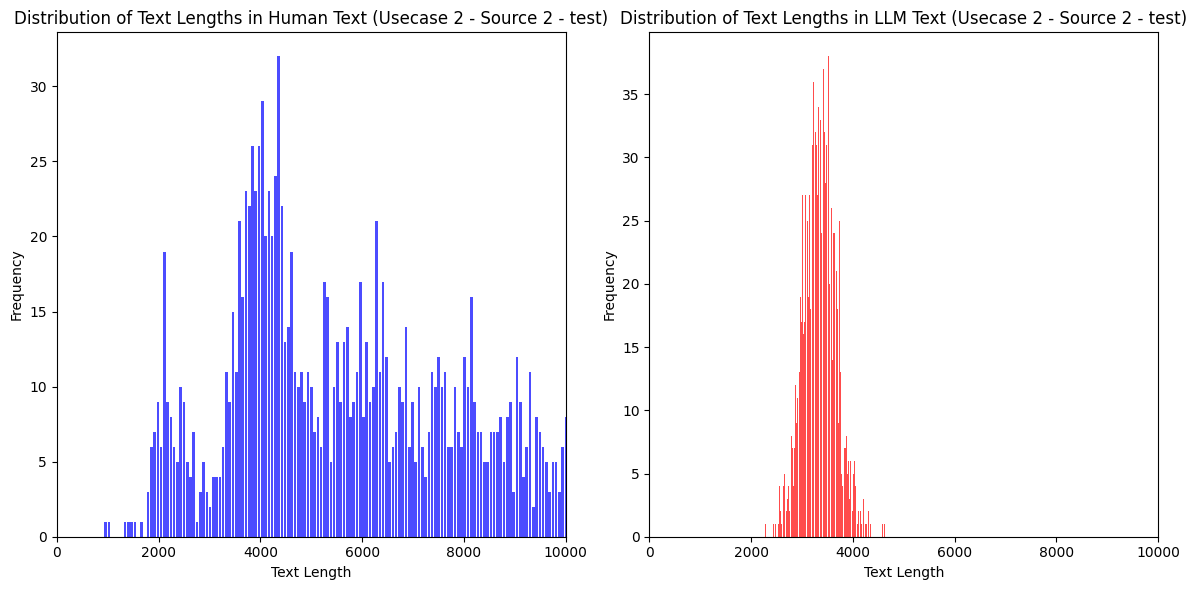

In [ ]:
# Calculate text length in data source 2
human_text_length = data_source_2_human['text'].apply(len)
llm_text_length = data_source_2_llm['text'].apply(len)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(human_text_length, bins=2000, alpha=0.7, label='Human Text', color='blue', rwidth=0.8)
plt.title('Distribution of Text Lengths in Human Text (Usecase 2 - Source 2 - test)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0,10000)

plt.subplot(1, 2, 2)
plt.hist(llm_text_length, bins=200, alpha=0.7, color='red', label='LLM Text', rwidth=0.8)
plt.title('Distribution of Text Lengths in LLM Text (Usecase 2 - Source 2 - test)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0,10000)

plt.tight_layout()
plt.show()

## Baseline: Roberta No Finetunning

In [ ]:
# Preparing the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
baseline_u2_nf = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

for param in baseline_u2_nf.roberta.parameters():
    param.requires_grad = False

train_encodings = tokenize_function(ctr2_train_data)
test_encodings = tokenize_function(ctr2_test_data)

train_dataset = Dataset(train_encodings, ctr2_train_data['label'].tolist())
test_dataset = Dataset(test_encodings, ctr2_test_data['label'].tolist())

# Initialize the trainer
trainer3 = Trainer(
    model=baseline_u2_nf,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer3.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.586000
1000,0.190800
1500,0.073900


TrainOutput(global_step=1818, training_loss=0.24398968112219546, metrics={'train_runtime': 527.518, 'train_samples_per_second': 27.537, 'train_steps_per_second': 3.446, 'total_flos': 3821951190159360.0, 'train_loss': 0.24398968112219546, 'epoch': 3.0})

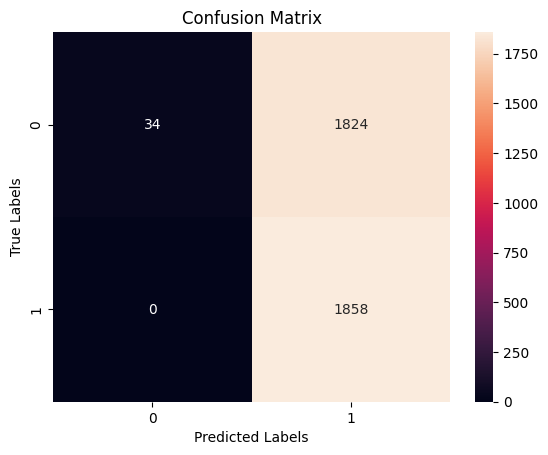

Accuracy: 0.5091496232508074
Precision: 0.5046170559478544
Recall: 1.0
F1 Score: 0.6707581227436823


In [ ]:
# Evaluation
predictions = trainer3.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Calculate metrics
accuracy = accuracy_score(ctr2_test_data['label'], preds)
precision, recall, f1, _ = precision_recall_fscore_support(ctr2_test_data['label'], preds, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr2_test_data['label'], preds)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

## Baseline: Roberta W/ Finetunning

In [ ]:
# Preparing the tokenizer and model
baseline_u2_wf = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Initialize the trainer
trainer4 = Trainer(
    model=baseline_u2_wf,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer4.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.090900
1000,0.048000
1500,0.007500


TrainOutput(global_step=1818, training_loss=0.040972995089225646, metrics={'train_runtime': 1565.1916, 'train_samples_per_second': 9.281, 'train_steps_per_second': 1.162, 'total_flos': 3821951190159360.0, 'train_loss': 0.040972995089225646, 'epoch': 3.0})

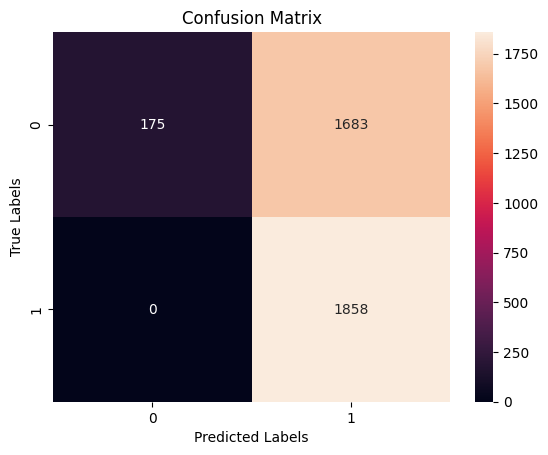

Accuracy: 0.5470936490850377
Precision: 0.524710533747529
Recall: 1.0
F1 Score: 0.6882756065938136


In [ ]:
# Evaluation
predictions = trainer4.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Calculate metrics
accuracy = accuracy_score(ctr2_test_data['label'], preds)
precision, recall, f1, _ = precision_recall_fscore_support(ctr2_test_data['label'], preds, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr2_test_data['label'], preds)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

## Proposed System

In this case, we explor the usage of two different model to produce sentence embedding. one is roberta, the othere is [wegmann style embedding](https://huggingface.co/AnnaWegmann/Style-Embedding) which is a model dedicate to capture styles

### base roberta embedding

#### train: gpt representation

In [ ]:
#@title archive train code

# class TextDataset(Dataset):
#     def __init__(self, texts):
#         self.texts = texts

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         return self.texts[idx]

# batch_size = 800

# # Load RoBERTa tokenizer and model
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base')

# # we are using the genreated sentence in the train to produce GPT represetnation
# gpt_sentences = list(ctr2_train_data[ctr2_train_data['label']==1]['text'])
# gpt_dataset = TextDataset(gpt_sentences)
# gpt_loader = DataLoader(gpt_dataset,
#                          batch_size=batch_size, shuffle=False)

# gpt_normalized_embeddings2 = []

# for batch in gpt_loader:
#     # Example sentence
#     gpt_encoded = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)

#     # Get model output (without pooling)
#     with torch.no_grad():
#         model_output = model(**gpt_encoded)
#         embeddings = model_output.last_hidden_state

#     # Perform mean pooling
#     input_mask_expanded = gpt_encoded['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
#     sum_embeddings = torch.sum(embeddings * input_mask_expanded, 1)
#     sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#     mean_pooled = sum_embeddings / sum_mask
#     # Normalize each mean-pooled embedding
#     normalized_embeddings = normalize(mean_pooled, p=2, dim=1)
#     # Append the results
#     gpt_normalized_embeddings2.append(normalized_embeddings)

# # Concatenate all batch results
# gpt_normalized_embeddings2 = torch.cat(gpt_normalized_embeddings2, dim=0)
# print("Normalized embeddings shape:", gpt_normalized_embeddings2.shape)  # Shape after normalization

In [ ]:
# we are using the genreated sentence in the train to produce GPT represetnation
gpt_sentences_u2 = list(ctr2_train_data[ctr2_train_data['label']==1]['text'])

base_roberta = SentenceTransformer('roberta-base')
usecase2_train_embeddings = base_roberta.encode(gpt_sentences_u2)
print("data domain 2 train embeddings shape:", usecase2_train_embeddings.shape)  # Shape after normalization

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


data domain 2 train embeddings shape: (2421, 768)


In [ ]:
gpt_representation2 = usecase2_train_embeddings.mean(axis=0)

#### dev: pick a threshold

In [ ]:
#@title archive dev code
# dev_sentences = list(ctr2_dev_data['text'])
# dev_dataset = TextDataset(dev_sentences)
# dev_loader = DataLoader(dev_dataset,
#                          batch_size=batch_size, shuffle=False)

# dev_normalized_embeddings2 = []

# for batch in dev_loader:
#     dev_encoded = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)

#     # Compute embeddings
#     with torch.no_grad():
#         dev_output = model(**dev_encoded)
#         embeddings = dev_output.last_hidden_state

#     # Mean pooling and normalization
#     dev_input_mask_expanded = dev_encoded['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
#     dev_sum_embeddings = torch.sum(embeddings * dev_input_mask_expanded, 1)
#     dev_sum_mask = torch.clamp(dev_input_mask_expanded.sum(1), min=1e-9)
#     dev_mean_pooled = dev_sum_embeddings / dev_sum_mask
#     normalized_embeddings = normalize(dev_mean_pooled, p=2, dim=1)

#     # Append the results
#     dev_normalized_embeddings2.append(normalized_embeddings)

# # Concatenate all batch results
# dev_normalized_embeddings2 = torch.cat(dev_normalized_embeddings2, dim=0)

# print("Dev embeddings shape:", dev_normalized_embeddings2.shape)

In [ ]:
dev_sentences_u2 = list(ctr2_dev_data['text'])

usecase2_dev_embeddings = base_roberta.encode(dev_sentences_u2)
print("data domain 2 dev embeddings shape:", usecase2_dev_embeddings.shape)  # Shape after normalization

data domain 2 dev embeddings shape: (412, 768)


In [ ]:
# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_dev2 = cosine_similarity(torch.from_numpy(gpt_representation2), torch.from_numpy(usecase2_dev_embeddings))

# Flatten cosine similarities to a list for easier processing
cosine_similarities_dev2 = cosine_similarities_dev2.flatten().numpy()

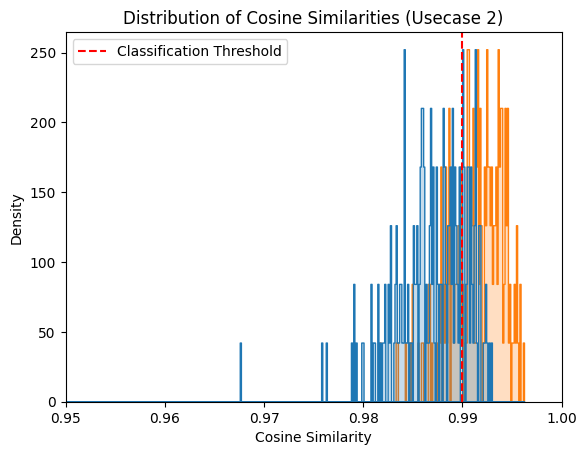

In [ ]:
threshold2 = 0.99

sns.histplot(x=cosine_similarities_dev2, hue=ctr2_dev_data['label'], element='step', stat='density', common_norm=False, bins=1000)
plt.axvline(x=threshold2, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities (Usecase 2)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.xlim(0.95, 1)
plt.show()

#### test

In [ ]:
#@title archive test code
# test_sentences = list(ctr2_test_data['text'])
# test_dataset = TextDataset(test_sentences)
# test_loader = DataLoader(test_dataset,
#                          batch_size=batch_size, shuffle=False)

# test_normalized_embeddings = []

# for batch in test_loader:
#     test_encoded = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)

#     # Compute embeddings
#     with torch.no_grad():
#         test_output = model(**test_encoded)
#         embeddings = test_output.last_hidden_state

#     # Mean pooling and normalization
#     test_input_mask_expanded = test_encoded['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
#     test_sum_embeddings = torch.sum(embeddings * test_input_mask_expanded, 1)
#     test_sum_mask = torch.clamp(test_input_mask_expanded.sum(1), min=1e-9)
#     test_mean_pooled = test_sum_embeddings / test_sum_mask
#     normalized_embeddings = normalize(test_mean_pooled, p=2, dim=1)

#     # Append the results
#     test_normalized_embeddings.append(normalized_embeddings)

# # Concatenate all batch results
# test_normalized_embeddings = torch.cat(test_normalized_embeddings, dim=0)

# print("Test embeddings shape:", test_normalized_embeddings.shape)

In [ ]:
test_sentences_u2 = list(ctr2_test_data['text'])

usecase2_test_embeddings = base_roberta.encode(test_sentences_u2)
print("data domain 2 test embeddings shape:", usecase2_test_embeddings.shape)  # Shape after normalization

data domain 2 test embeddings shape: (3716, 768)


In [ ]:
# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_test2 = cosine_similarity(torch.from_numpy(gpt_representation2), torch.from_numpy(usecase2_test_embeddings))

# Flatten cosine similarities to a list for easier processing
cosine_similarities_test2 = cosine_similarities_test2.flatten().numpy()

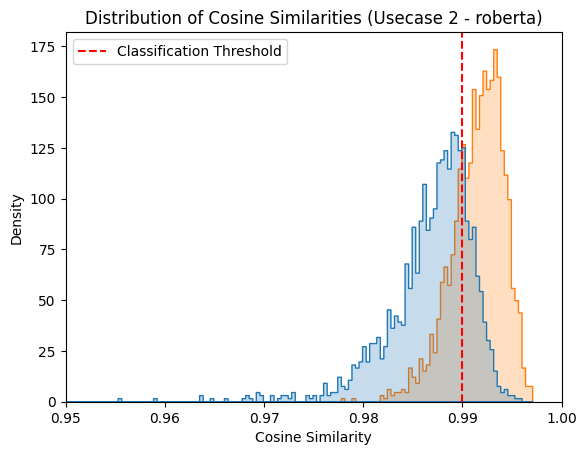

In [ ]:
sns.histplot(x=cosine_similarities_test2, hue=ctr2_test_data['label'], element='step', stat='density', common_norm=False, bins=1000)
plt.axvline(x=threshold2, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities (Usecase 2 - roberta)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.xlim(0.95, 1)
plt.show()

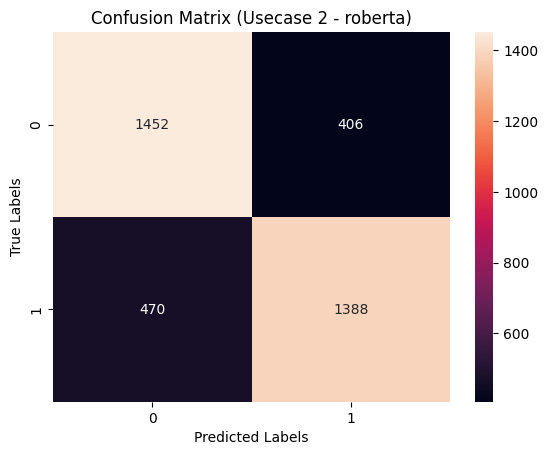

Accuracy: 0.7642626480086114
Precision: 0.7736900780379041
Recall: 0.7470398277717977
F1 Score: 0.7601314348302302


In [ ]:
predicted_labels = (cosine_similarities_test2 > threshold2).astype(int)

# Calculate metrics
accuracy = accuracy_score(ctr2_test_data['label'], predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(ctr2_test_data['label'], predicted_labels, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr2_test_data['label'], predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Usecase 2 - roberta)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

### wegmann

#### train: gpt representation

In [ ]:
#@title archive train code

# from sentence_transformers import SentenceTransformer

# # Load sentence transformer model
# wegmann_model = SentenceTransformer('AnnaWegmann/Style-Embedding')
# gpt_sentences = list(ctr2_train_data[ctr2_train_data['label']==1]['text'])  # Assuming ctr2_train_data is your dataset
# gpt_dataset = TextDataset(gpt_sentences)
# gpt_loader = DataLoader(gpt_dataset, batch_size=batch_size, shuffle=False)

# gpt_normalized_wegmann_embeddings = []

# for batch in gpt_loader:
#     # Compute embeddings using the sentence transformer
#     with torch.no_grad():
#         embeddings = wegmann_model.encode(batch, convert_to_tensor=True, show_progress_bar=False)

#     # Normalize each mean-pooled embedding
#     normalized_embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
#     # Append the results
#     gpt_normalized_wegmann_embeddings.append(normalized_embeddings)

# # Concatenate all batch results
# gpt_normalized_wegmann_embeddings = torch.cat(gpt_normalized_wegmann_embeddings, dim=0)
# print("Normalized embeddings shape:", gpt_normalized_wegmann_embeddings.shape)  # Shape after normalization

# # Compute the overall GPT representation by averaging normalized embeddings
# gpt_wegmann_representation = gpt_normalized_wegmann_embeddings.mean(dim=0)

In [ ]:
# we are using the genreated sentence in the train to produce GPT represetnation
gpt_sentences_u2 = list(ctr2_train_data[ctr2_train_data['label']==1]['text'])

wegmann = SentenceTransformer('AnnaWegmann/Style-Embedding')
usecase2_train_wegmann_embeddings = wegmann.encode(gpt_sentences_u2)
gpt_representation2_wegmann = usecase2_train_wegmann_embeddings.mean(axis=0)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/354 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### dev: pick a threshold

In [ ]:
#@title archive dev code
# dev_sentences = list(ctr2_dev_data['text'])
# dev_dataset = TextDataset(dev_sentences)
# dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# dev_normalized_wegmann_embeddings = []

# for batch in dev_loader:
#     # Compute embeddings using the sentence transformer
#     with torch.no_grad():
#         embeddings = wegmann_model.encode(batch, convert_to_tensor=True, show_progress_bar=False)

#     # Normalize each embedding
#     normalized_embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
#     # Append the results
#     dev_normalized_wegmann_embeddings.append(normalized_embeddings)

# # Concatenate all batch results
# dev_normalized_wegmann_embeddings = torch.cat(dev_normalized_wegmann_embeddings, dim=0)

In [ ]:
dev_sentences_u2 = list(ctr2_dev_data['text'])

usecase2_dev_wegmann_embeddings = wegmann.encode(dev_sentences_u2)

In [ ]:
# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_dev2_wegmann = cosine_similarity(torch.from_numpy(gpt_representation2_wegmann), torch.from_numpy(usecase2_dev_wegmann_embeddings))

# Flatten cosine similarities to a list for easier processing
cosine_similarities_dev2_wegmann = cosine_similarities_dev2_wegmann.flatten().cpu().numpy()

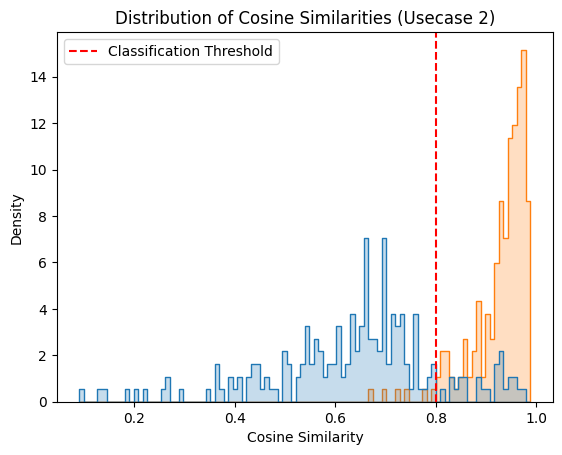

In [ ]:
threshold3 = 0.8

sns.histplot(x=cosine_similarities_dev2_wegmann, hue=ctr2_dev_data['label'], element='step', stat='density', common_norm=False, bins=100)
plt.axvline(x=threshold3, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities (Usecase 2)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

#### test

In [ ]:
#@title archive test code
# # Assuming the model is already loaded from the previous code block
# # model = SentenceTransformer('AnnaWegmann/Style-Embedding')
# test_sentences = list(ctr2_test_data['text'])  # Assuming ctr2_test_data is your dataset
# test_dataset = TextDataset(test_sentences)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# test_normalized_wegmann_embeddings = []

# for batch in test_loader:
#     # Compute embeddings using the sentence transformer
#     with torch.no_grad():
#         embeddings = wegmann_model.encode(batch, convert_to_tensor=True, show_progress_bar=False)

#     # Normalize each embedding
#     normalized_embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
#     # Append the results
#     test_normalized_wegmann_embeddings.append(normalized_embeddings)

# # Concatenate all batch results
# test_normalized_wegmann_embeddings = torch.cat(test_normalized_wegmann_embeddings, dim=0)
# print("Test embeddings shape:", test_normalized_wegmann_embeddings.shape)  # Shape after normalization


In [ ]:
test_sentences_u2 = list(ctr2_test_data['text'])

usecase2_test_wegmann_embeddings = wegmann.encode(test_sentences_u2)

In [ ]:
# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_test2_wegmann = cosine_similarity(torch.from_numpy(gpt_representation2_wegmann), torch.from_numpy(usecase2_test_wegmann_embeddings))

# Flatten cosine similarities to a list for easier processing
cosine_similarities_test2_wegmann = cosine_similarities_test2_wegmann.flatten().numpy()

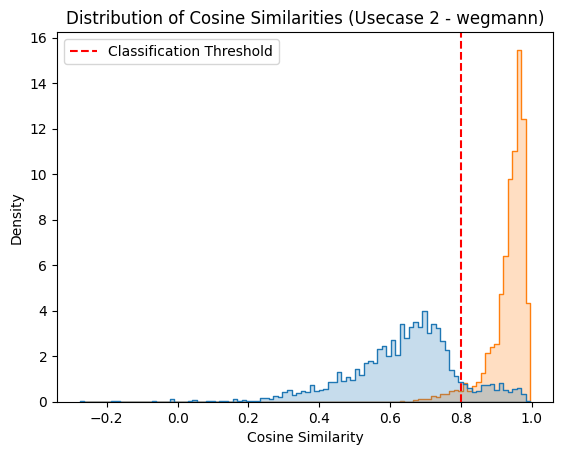

In [ ]:
sns.histplot(x=cosine_similarities_test2_wegmann, hue=ctr2_test_data['label'], element='step', stat='density', common_norm=False, bins=100)
plt.axvline(x=threshold3, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities (Usecase 2 - wegmann)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

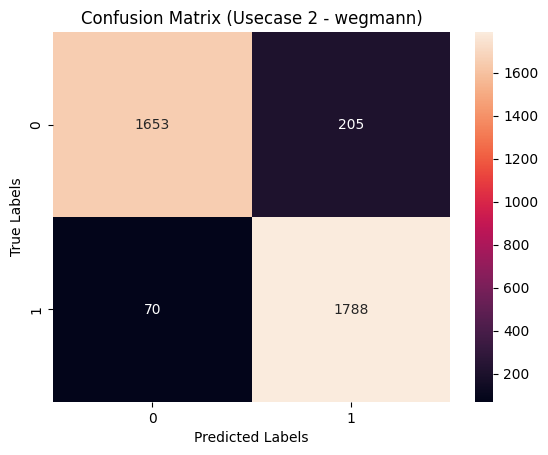

Accuracy: 0.9259956942949408
Precision: 0.8971399899648771
Recall: 0.9623250807319699
F1 Score: 0.9285899766294469


In [ ]:
predicted_labels = (cosine_similarities_test2_wegmann > threshold3).astype(int)

# Calculate metrics
accuracy = accuracy_score(ctr2_test_data['label'], predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(ctr2_test_data['label'], predicted_labels, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr2_test_data['label'], predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Usecase 2 - wegmann)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Usecase 3

## data loading, split

In [ ]:
# # llm train
# u3_llm_train = pd.DataFrame(
#     load_dataset('jjz5463/llm-detection-generation-failcase-train', #llm-detection-generation-contribution2-train
#                  split='train')
#     )[['generations by the LLM.']]
# u3_llm_train.rename(columns={'generations by the LLM.': 'text'}, inplace=True)
# u3_llm_train['label'] = 1
# u3_llm_train.shape

In [ ]:
%%capture
# llm test
u3_llm_test = pd.DataFrame(
    load_dataset('jjz5463/llm-detection-generation-failcase-test',
                 split='train')
    )[['generations by the LLM.']]
u3_llm_test.rename(columns={'generations by the LLM.': 'text'}, inplace=True)
u3_llm_test['label'] = 1

In [ ]:
# training data, use human data from usecase 2
ctr3_train_data = ctr2_train_data#pd.concat([data_source_1_human, u3_llm_train])
ctr3_train_data.shape

(4842, 2)

In [ ]:
# testing data
ctr3_test_data = pd.concat([data_source_2_human, u3_llm_test])

# split dev from test
ctr3_dev_data, ctr3_test_data = train_test_split(ctr3_test_data, test_size=0.9, stratify=ctr3_test_data['label'], random_state=42)
ctr3_test_data.shape

(3716, 2)

In [ ]:
# dev data
ctr3_dev_data.shape

(412, 2)

## Baseline: Roberta No Finetunning

In [ ]:
# Preparing the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
baseline_u3_nf = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

for param in baseline_u3_nf.roberta.parameters():
    param.requires_grad = False

train_encodings = tokenize_function(ctr3_train_data)
test_encodings = tokenize_function(ctr3_test_data)

train_dataset = Dataset(train_encodings, ctr3_train_data['label'].tolist())
test_dataset = Dataset(test_encodings, ctr3_test_data['label'].tolist())

# Initialize the trainer
trainer5 = Trainer(
    model=baseline_u3_nf,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer5.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.586000
1000,0.190800
1500,0.073900


TrainOutput(global_step=1818, training_loss=0.24398968112219546, metrics={'train_runtime': 529.4154, 'train_samples_per_second': 27.438, 'train_steps_per_second': 3.434, 'total_flos': 3821951190159360.0, 'train_loss': 0.24398968112219546, 'epoch': 3.0})

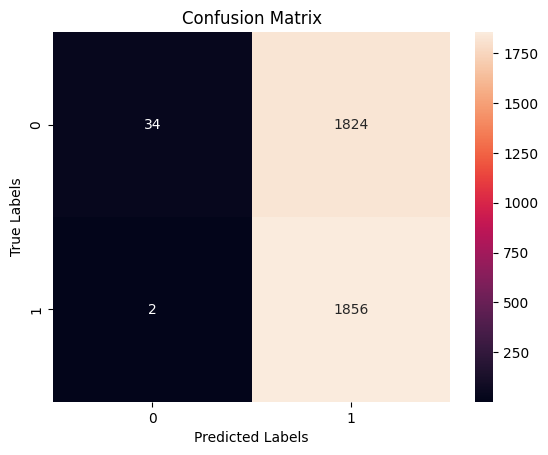

Accuracy: 0.5086114101184069
Precision: 0.5043478260869565
Recall: 0.9989235737351991
F1 Score: 0.670278078728783


In [ ]:
# Evaluation
predictions = trainer5.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Calculate metrics
accuracy = accuracy_score(ctr3_test_data['label'], preds)
precision, recall, f1, _ = precision_recall_fscore_support(ctr3_test_data['label'], preds, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_test_data['label'], preds)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

## Baseline: Roberta W/ Finetunning

In [ ]:
# Preparing the tokenizer and model
baseline_u3_wf = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Initialize the trainer
trainer6 = Trainer(
    model=baseline_u3_wf,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer6.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.090900
1000,0.048000
1500,0.007500


TrainOutput(global_step=1818, training_loss=0.040972995089225646, metrics={'train_runtime': 1563.1203, 'train_samples_per_second': 9.293, 'train_steps_per_second': 1.163, 'total_flos': 3821951190159360.0, 'train_loss': 0.040972995089225646, 'epoch': 3.0})

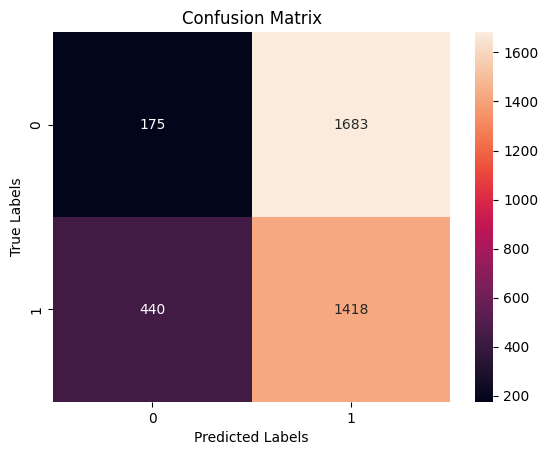

Accuracy: 0.42868675995694294
Precision: 0.45727184779103514
Recall: 0.7631862217438106
F1 Score: 0.5718894938495664


In [ ]:
# Evaluation
predictions = trainer6.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Calculate metrics
accuracy = accuracy_score(ctr3_test_data['label'], preds)
precision, recall, f1, _ = precision_recall_fscore_support(ctr3_test_data['label'], preds, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_test_data['label'], preds)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

### base roberta embedding

In [ ]:
# train, we are using the genreated sentence in the train to produce GPT represetnation
gpt_sentences_u3 = list(ctr3_train_data[ctr3_train_data['label']==1]['text'])

base_roberta = SentenceTransformer('roberta-base')
usecase3_train_embeddings = base_roberta.encode(gpt_sentences_u3)
gpt_representation3 = usecase3_train_embeddings.mean(axis=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


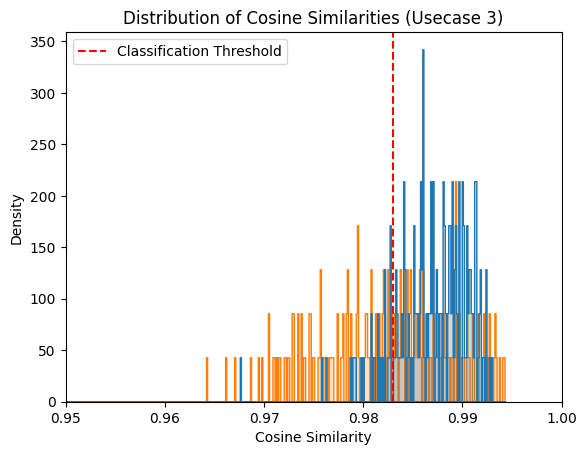

In [ ]:
# dev
dev_sentences_u3 = list(ctr3_dev_data['text'])

usecase3_dev_embeddings = base_roberta.encode(dev_sentences_u3)

# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_dev3 = cosine_similarity(torch.from_numpy(gpt_representation3), torch.from_numpy(usecase3_dev_embeddings))
# Flatten cosine similarities to a list for easier processing
cosine_similarities_dev3 = cosine_similarities_dev3.flatten().numpy()

threshold4 = 0.983

sns.histplot(x=cosine_similarities_dev3, hue=ctr3_dev_data['label'], element='step', stat='density', common_norm=False, bins=1000)
plt.axvline(x=threshold4, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities (Usecase 3)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.xlim(0.95, 1)
plt.show()

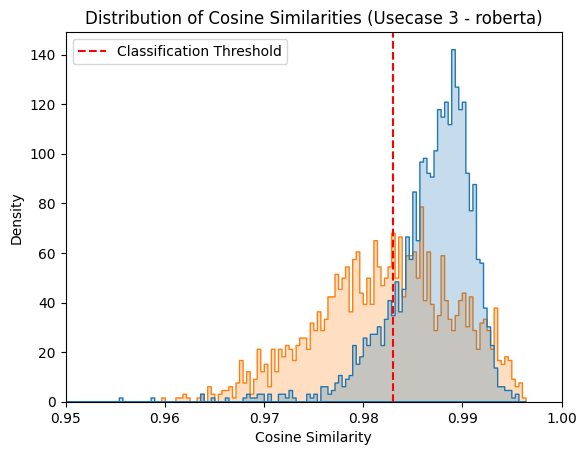

In [ ]:
# test
test_sentences_u3 = list(ctr3_test_data['text'])

usecase3_test_embeddings = base_roberta.encode(test_sentences_u3)

# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_test3 = cosine_similarity(torch.from_numpy(gpt_representation3), torch.from_numpy(usecase3_test_embeddings))
# Flatten cosine similarities to a list for easier processing
cosine_similarities_test3 = cosine_similarities_test3.flatten().numpy()

sns.histplot(x=cosine_similarities_test3, hue=ctr3_test_data['label'], element='step', stat='density', common_norm=False, bins=1000)
plt.axvline(x=threshold4, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities (Usecase 3 - roberta)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.xlim(0.95, 1)
plt.show()

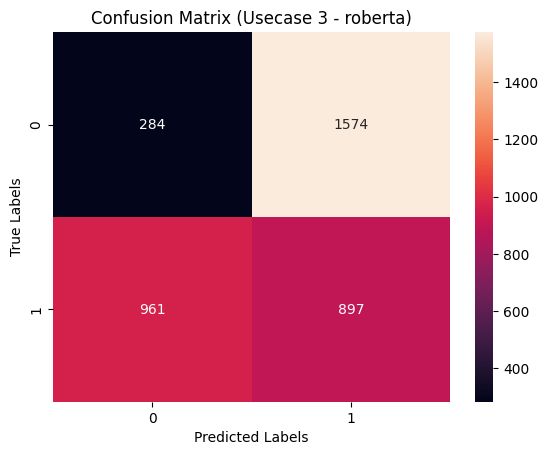

Accuracy: 0.31781485468245424
Precision: 0.3630109267503035
Recall: 0.48277717976318624
F1 Score: 0.41441441441441434


In [ ]:
predicted_labels = (cosine_similarities_test3 > threshold4).astype(int)

# Calculate metrics
accuracy = accuracy_score(ctr3_test_data['label'], predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(ctr3_test_data['label'], predicted_labels, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_test_data['label'], predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Usecase 3 - roberta)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

### wegmann embedding

In [ ]:
# train, we are using the genreated sentence in the train to produce GPT represetnation
gpt_sentences_u3 = list(ctr3_train_data[ctr3_train_data['label']==1]['text'])

wegmann = SentenceTransformer('AnnaWegmann/Style-Embedding')
usecase3_train_wegmann_embeddings = wegmann.encode(gpt_sentences_u3)
gpt_representation3_wegmann = usecase3_train_wegmann_embeddings.mean(axis=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


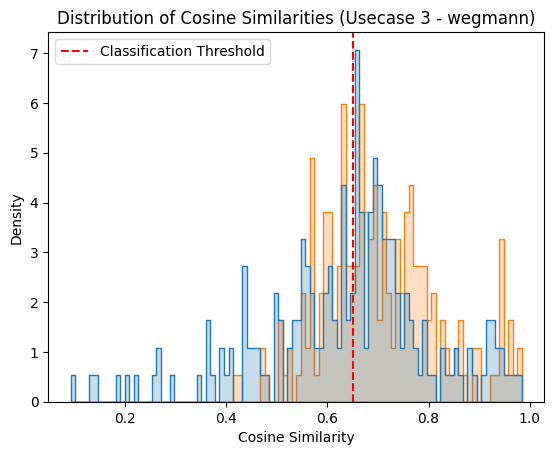

In [ ]:
# dev
dev_sentences_u3 = list(ctr3_dev_data['text'])
usecase3_dev_wegmann_embeddings = wegmann.encode(dev_sentences_u3)

# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_dev3_wegmann = cosine_similarity(torch.from_numpy(gpt_representation3_wegmann), torch.from_numpy(usecase3_dev_wegmann_embeddings))
# Flatten cosine similarities to a list for easier processing
cosine_similarities_dev3_wegmann = cosine_similarities_dev3_wegmann.flatten().cpu().numpy()

threshold5 = 0.65

sns.histplot(x=cosine_similarities_dev3_wegmann, hue=ctr3_dev_data['label'], element='step', stat='density', common_norm=False, bins=100)
plt.axvline(x=threshold5, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities (Usecase 3 - wegmann)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

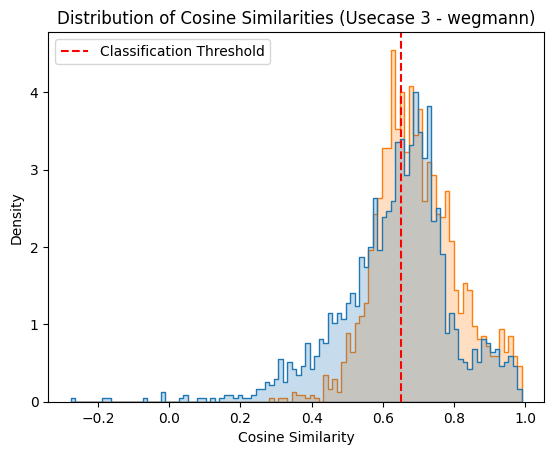

In [ ]:
# test
test_sentences_u3 = list(ctr3_test_data['text'])
usecase3_test_wegmann_embeddings = wegmann.encode(test_sentences_u3)

# Cosine Similarity: Compare GPT representation with a new sentence
cosine_similarities_test3_wegmann = cosine_similarity(torch.from_numpy(gpt_representation3_wegmann), torch.from_numpy(usecase3_test_wegmann_embeddings))
# Flatten cosine similarities to a list for easier processing
cosine_similarities_test3_wegmann = cosine_similarities_test3_wegmann.flatten().numpy()

sns.histplot(x=cosine_similarities_test3_wegmann, hue=ctr3_test_data['label'], element='step', stat='density', common_norm=False, bins=100)
plt.axvline(x=threshold5, color='red', linestyle='--', label='Classification Threshold')
plt.title('Distribution of Cosine Similarities (Usecase 3 - wegmann)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

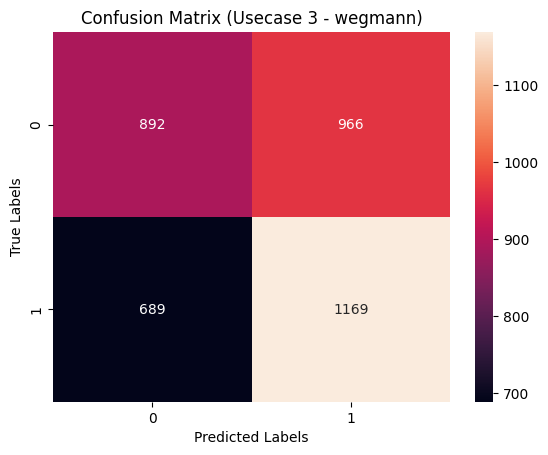

Accuracy: 0.5546286329386437
Precision: 0.5475409836065573
Recall: 0.6291711517761034
F1 Score: 0.5855246681692962


In [ ]:
predicted_labels = (cosine_similarities_test3_wegmann > threshold5).astype(int)

# Calculate metrics
accuracy = accuracy_score(ctr3_test_data['label'], predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(ctr3_test_data['label'], predicted_labels, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_test_data['label'], predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Usecase 3 - wegmann)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Conclusion

In [ ]:
table_usecase1 = pd.DataFrame({
    "Accuracy": [0.9572994806693594, 0.9994229659549914, 0.9982688978649741],
    "Precision": [0.9212765957446809, 0.9988465974625144, 0.996547756041427],
    "Recall": [1.0, 1.0, 1.0],
    "F1 Score": [0.9590254706533776, 0.9994229659549912, 0.998270893371758]
}, index=["Baseline: Roberta No Finetuning", "Baseline: Roberta W/ Finetuning", "Proposed: GPT-Rep-Roberta"])

table_usecase2 = pd.DataFrame({
    "Accuracy": [0.5096878363832078, 0.5320236813778256, 0.7642626480086114, 0.9259956942949408],
    "Precision": [0.5048913043478261, 0.516541562413122, 0.7736900780379041, 0.8971399899648771],
    "Recall": [1.0, 1.0, 0.7470398277717977, 0.9623250807319699],
    "F1 Score": [0.6710003611412062, 0.6812098991750687, 0.7601314348302302, 0.9285899766294469]
}, index=["Baseline: Roberta No Finetuning",
          "Baseline: Roberta W/ Finetuning",
          "Proposed: GPT-Rep-Roberta",
          "Proposed: GPT-Rep-Wegmann"])

table_usecase3 = pd.DataFrame({
    "Accuracy": [0.5091496232508074, 0.5104951560818084, 0.31781485468245424, 0.5546286329386437],
    "Precision": [0.5046220772158782, 0.505544498151834, 0.3630109267503035, 0.5475409836065573],
    "Recall": [0.9989235737351991, 0.9569429494079655, 0.48277717976318624, 0.6291711517761034],
    "F1 Score": [0.6705202312138728, 0.6615813953488373, 0.41441441441441434, 0.5855246681692962]
}, index=["Baseline: Roberta No Finetuning",
          "Baseline: Roberta W/ Finetuning",
          "Proposed: GPT-Rep-Roberta",
          "Proposed: GPT-Rep-Wegmann"])

In [ ]:
table_usecase1

,Accuracy,Precision,Recall,F1 Score
Baseline: Roberta No Finetuning,0.957299,0.921277,1.0,0.959025
Baseline: Roberta W/ Finetuning,0.999423,0.998847,1.0,0.999423
Proposed: GPT-Rep-Roberta,0.998269,0.996548,1.0,0.998271


In [ ]:
table_usecase2

,Accuracy,Precision,Recall,F1 Score
Baseline: Roberta No Finetuning,0.509688,0.504891,1.000000,0.671000
Baseline: Roberta W/ Finetuning,0.532024,0.516542,1.000000,0.681210
Proposed: GPT-Rep-Roberta,0.764263,0.773690,0.747040,0.760131
Proposed: GPT-Rep-Wegmann,0.925996,0.897140,0.962325,0.928590


In [ ]:
table_usecase3

,Accuracy,Precision,Recall,F1 Score
Baseline: Roberta No Finetuning,0.509150,0.504622,0.998924,0.670520
Baseline: Roberta W/ Finetuning,0.510495,0.505544,0.956943,0.661581
Proposed: GPT-Rep-Roberta,0.317815,0.363011,0.482777,0.414414
Proposed: GPT-Rep-Wegmann,0.554629,0.547541,0.629171,0.585525
